Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [19]:
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install "gymnasium[all]"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.1.0
    Uninstalling Shimmy-1.1.0:
      Successfully uninstalled Shimmy-1.1.0
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [47]:
import aerosandbox as asb
import aerosandbox.numpy as np
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)

	# construct and safe self.vlm()
	def runAero(self) -> dict[str, any]:
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		return self.vlm.run()  # Returns a dictionary
		
	# get observations from current self.xsecs
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)

		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		#TODO: Scale the bounds by timesteps to identify max deviation, apply to initial point, and get accurately bounded observation space
		self.observation_space = spaces.Box(low=-100, high=100, shape=(len(low),))
		
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le = [[0, i*initialYSpacing, 0] for i in range(self.numChords)]
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		
	def step(self, action):
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec

			# Apply dX, dY, dZ
			newXYZ_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le= ([0,0,0] if i == 0 else newXYZ_le),
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		aero = self.runAero()

		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = liftCoeff/dragCoeff 					# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = bool(reward >= 120) 				# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = bool(reward >= 120)	 				# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": liftCoeff, "drag": dragCoeff}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	
	def reset(self, seed=123):
		super().reset(seed=seed)
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,            
					xsecs=self.xsecs
				),
			],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.vlm.run()
		self.airplane.draw_three_view()
		self.vlm.draw()
	
	def close (self):
		...

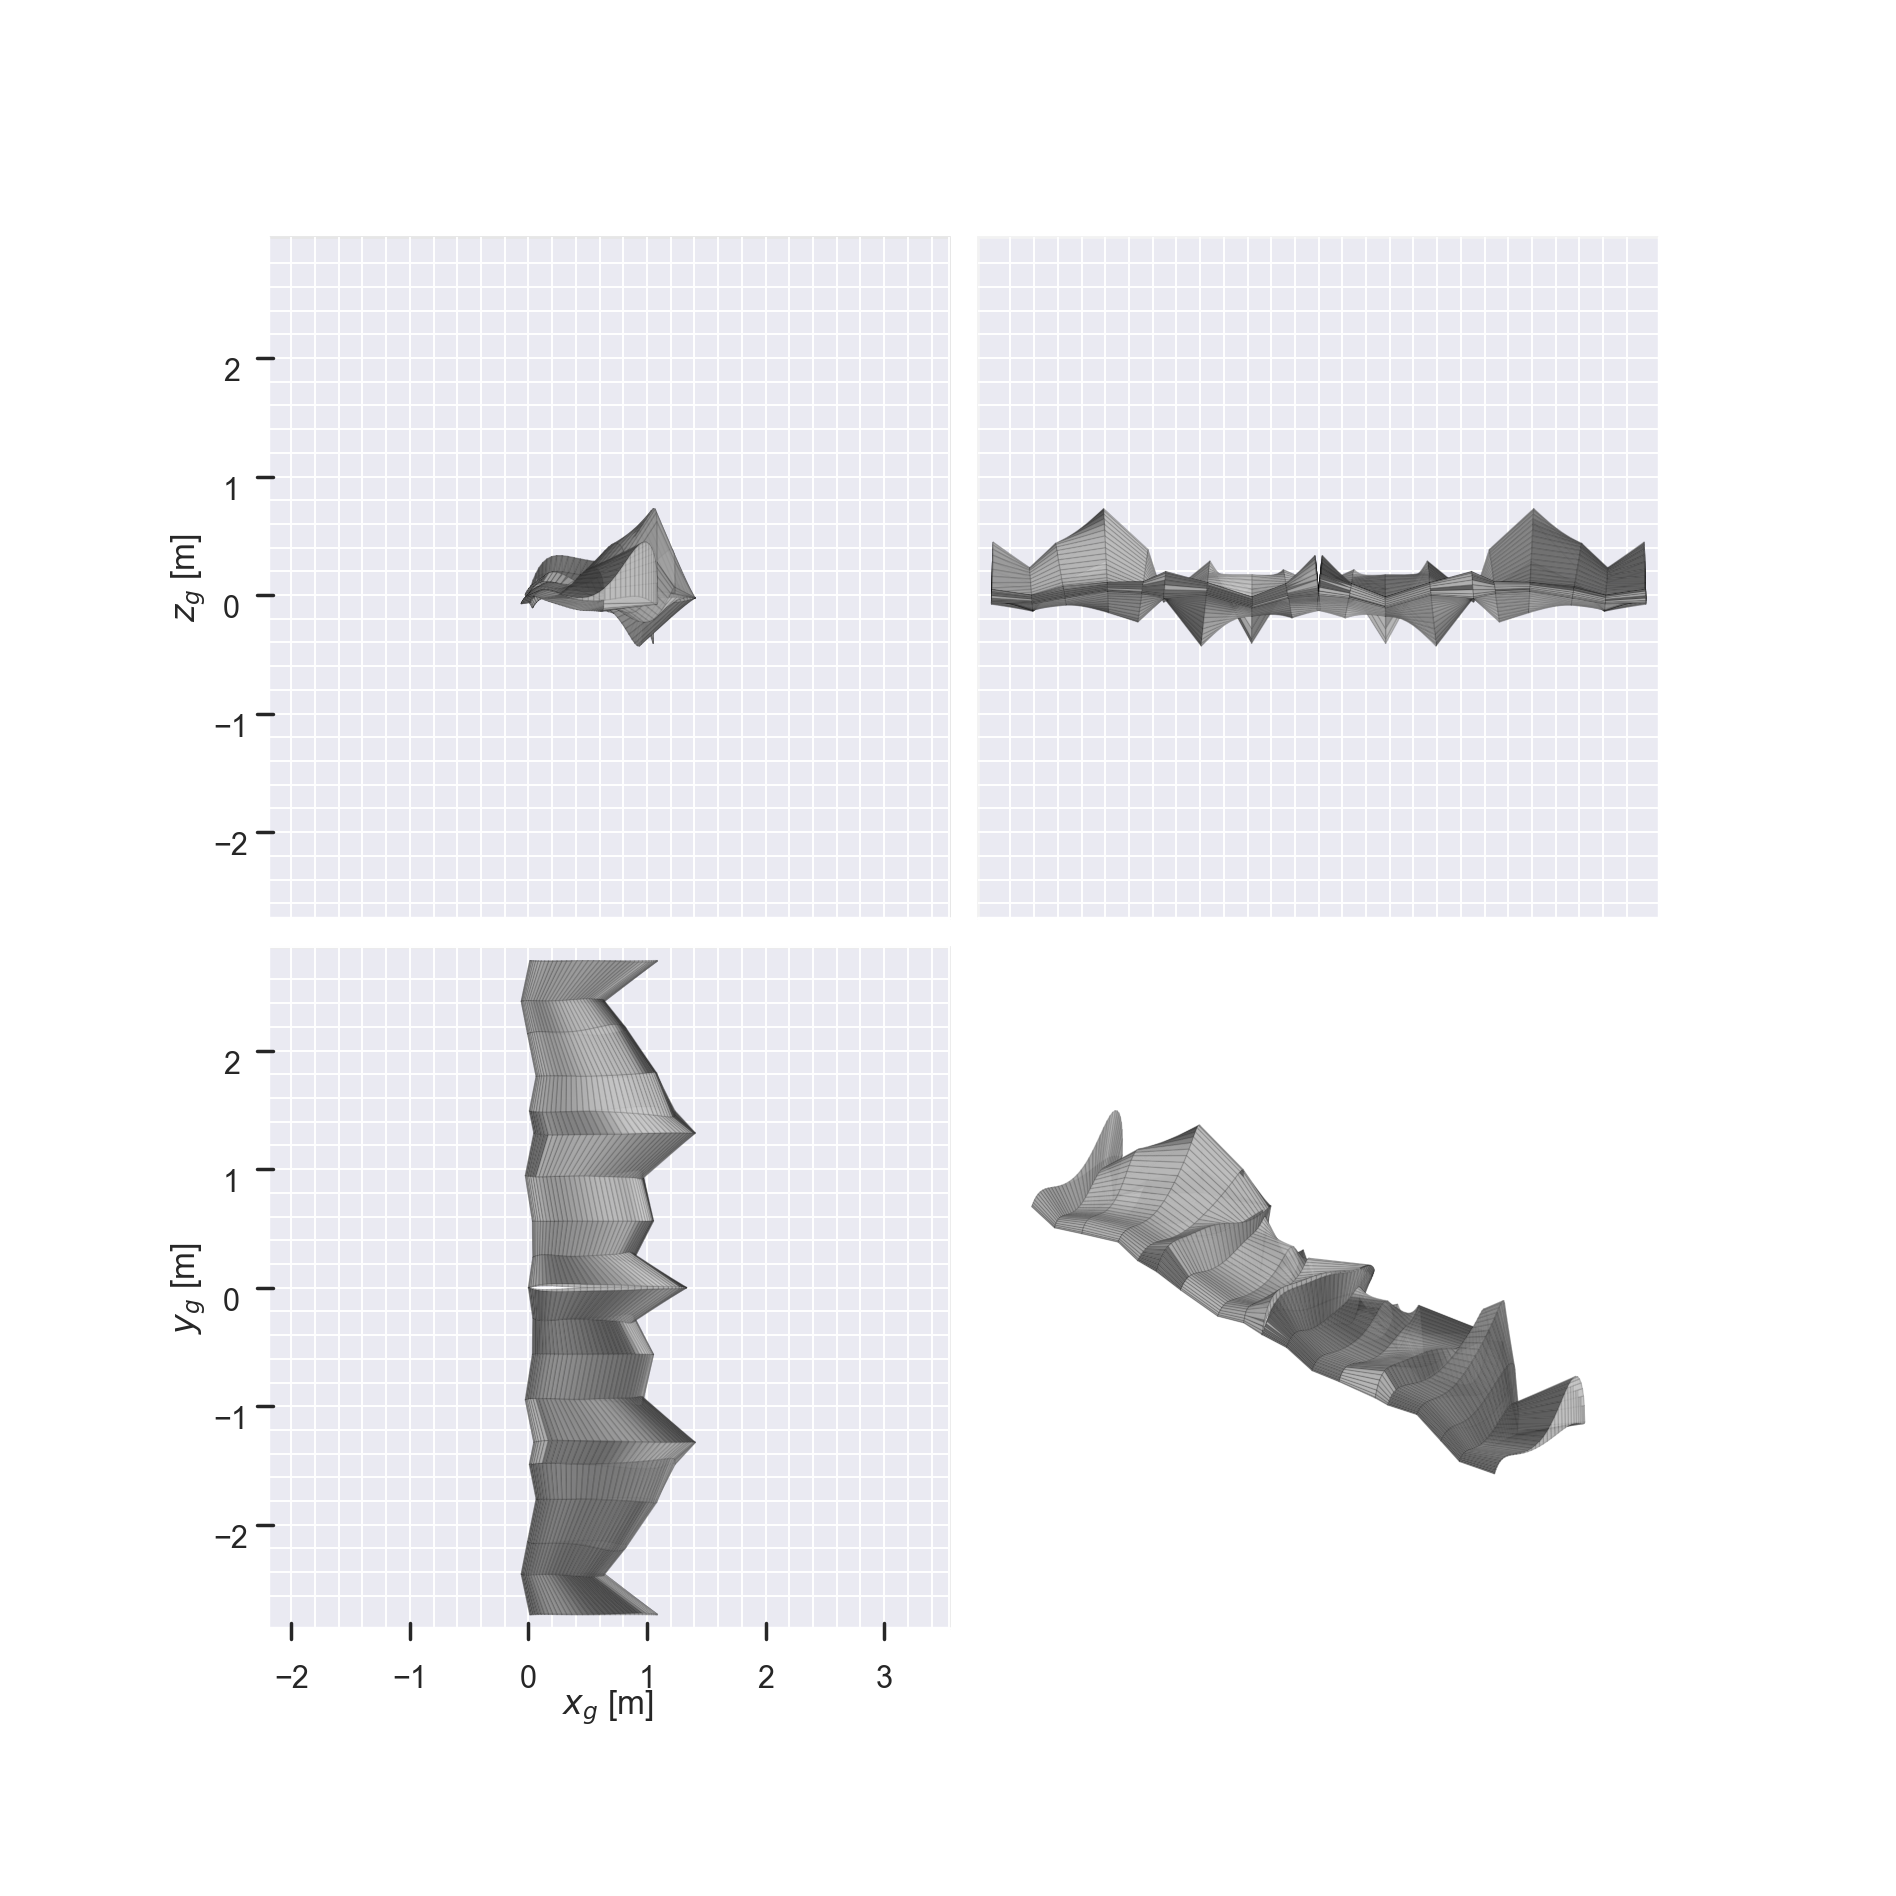

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


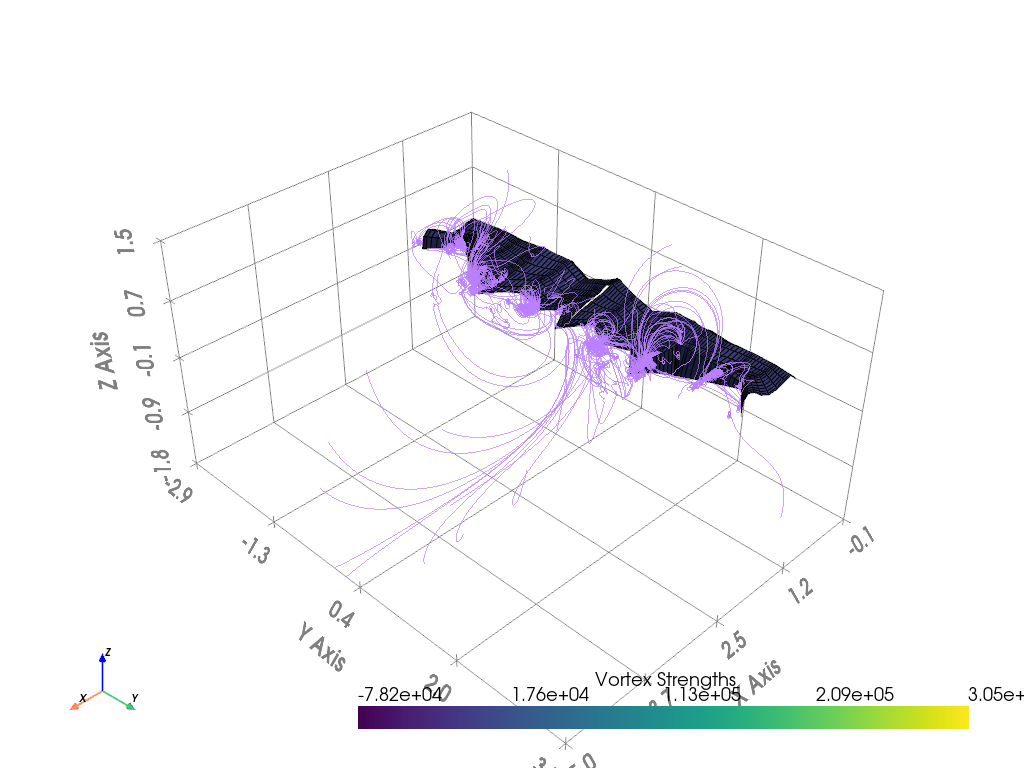

In [50]:
env = AeroEnv(
    numChords=10, 
	initialYSpacing=0.3, 
	initialChordLength=1, 
	initialUpperKulfan=1.5, 
	initialLowerKulfan=-0.3, 
	initialLEW=0.3, 
	initialN1=2, 
	initialN2=1, 
    dX_bounds = (-0.05, 0.05),
	dY_bounds = (-0.05, 0.05),
	dZ_bounds = (-0.05, 0.05),
	dChord_bounds = (-0.2, 0.2),
	dTwist_bounds = (0, 0),
	KT_bounds = (-0.5, 2),
	KB_bounds = (-1, 0.5),
	N_bounds = (1, 4),
	LEW_bounds = (0, 1),
	kulfanWeightResolution = 7)

obs = env.reset()
random_action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(random_action)
random_action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(random_action)
random_action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(random_action)
env.render()
obs, info = env.reset()



In [ ]:
!{sys.executable} -m pip install 'stable_baselines3[extra]'

Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-1.1.0-py3-none-any.whl (37 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [51]:
from stable_baselines3 import PPO
import os
import time

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = AeroEnv()
env.reset()

model = PPO(
    n_steps=10,
    batch_size=30,
    policy="MlpPolicy",
    env=env, 
    verbose=2)

total_timesteps = 600
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

num_episodes = 5
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    while not done:
        action = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env.render()
env.close()


TypeError: __init__() missing 18 required positional arguments: 'kulfanWeightResolution', 'numChords', 'initialYSpacing', 'initialChordLength', 'initialUpperKulfan', 'initialLowerKulfan', 'initialLEW', 'initialN1', 'initialN2', 'dX_bounds', 'dY_bounds', 'dZ_bounds', 'dChord_bounds', 'dTwist_bounds', 'KT_bounds', 'KB_bounds', 'N_bounds', and 'LEW_bounds'